In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(cowplot))
library(grid)
library(aplot)
library(anndata)
library(ggplot2)
library(patchwork)
library(scales)
library(jsonlite)


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [3]:
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  
  if(luminance < 128){
  return('white')   
  } else{return('black')}
}
hex_to_rgb <- function(hex) {
  hex <- gsub("#", "", hex)
  r <- strtoi(substr(hex, 1, 2), 16L)
  g <- strtoi(substr(hex, 3, 4), 16L)
  b <- strtoi(substr(hex, 5, 6), 16L)
  return(c(r, g, b))
}

rgb_to_hex <- function(rgb) {
  return(sprintf("#%02X%02X%02X", rgb[1], rgb[2], rgb[3]))
}

average_color <- function(colors) {
  rgb_values <- t(sapply(colors, hex_to_rgb))
  avg_rgb <- colMeans(rgb_values)
  avg_rgb <- round(avg_rgb)
  return(rgb_to_hex(avg_rgb))
}

flatten_to_df <- function(data, level1) {
  result <- data.frame(Level1 = character(), Level2 = character(), Level3 = character(), stringsAsFactors = FALSE)
  for (key in names(data)) {
    if (is.list(data[[key]])) {
      for (subkey in names(data[[key]])) {
        for (item in data[[key]][[subkey]]) {
          result <- rbind(result, data.frame(Level1 = key, Level2 = subkey, Level3 = item, stringsAsFactors = FALSE))
        }
      }
    } else {
      result <- rbind(result, data.frame(Level1 = key, Level2 = NA, Level3 = data[[key]], stringsAsFactors = FALSE))
    }
  }
  return(result)
}

thousands_labels <- function(x) {
  paste0(round(x/1000,1), "k")
}

### Annotation Bar for level 3

In [4]:
labels_df<-read.csv('/home//jupyter/BRI_Figures_Final_V2/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')

labels_df$annotation_color <- sapply(labels_df$color, is_dark_color)
color_vector <- setNames(labels_df$color, labels_df$label)
color_vector_annotation <- setNames(labels_df$annotation_color, labels_df$label)

labels_df$xmin<-labels_df$xpos-0.5
labels_df$xmax<-labels_df$xpos+0.5

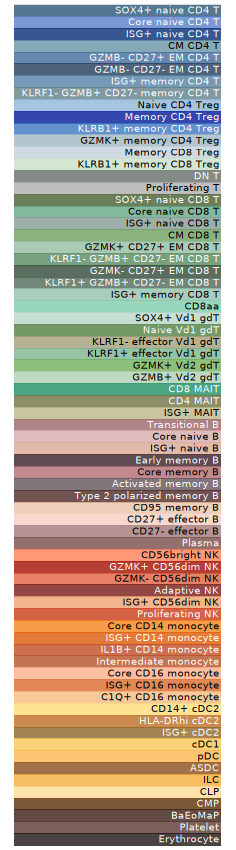

In [4]:
options(repr.plot.width = 50/25.4, repr.plot.height = 180/25.4)

L3_Annotation <- ggplot() +
  geom_rect(data = labels_df,
            aes(ymin = xmin-1, 
                ymax = xmax-1, 
                xmin = 0, 
                xmax = 1, 
                fill = label),
            alpha = 0.8) +
  scale_fill_manual(values = color_vector) +
  geom_text(data = labels_df,size=2.1, size.unit='mm',
            aes(y = xmax-1.5, 
                x = 0.99, 
                label = gsub(' cell', '', label), 
                color = label), 
            angle = 0, 
            vjust = 0.4, 
            hjust = 1) + 
  scale_color_manual(values = color_vector_annotation) +
  scale_y_reverse(limits = c(70.5, -0.5), expand = c(0, 0)) +
  theme(axis.line = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.background = element_blank(),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.background = element_blank(),
        legend.position = "none", 
        plot.margin=grid::unit(c(1,1,0,0), "mm"))  # Set global font family to Arial

L3_Annotation

### Annotation Bar for level 1 and level 2 

In [6]:
celltype_mapping<-fromJSON('/home//jupyter/BRI_Figures_Final_V2/Celltype_Mapping/AIFI_Reference.json', flatten = TRUE)
celltype_mapping <- flatten_to_df(celltype_mapping, names(celltype_mapping))


In [7]:
labels_df<-left_join(labels_df,celltype_mapping,by=c('label'='Level3'))

In [8]:
labels_df<-labels_df %>%
  group_by(Level2) %>%
  mutate(Level2_color = average_color(color)) %>%
  ungroup()%>%
  group_by(Level1) %>%
  mutate(Level1_color = average_color(Level2_color)) %>%
  ungroup()

In [8]:
options(repr.plot.width = 5/25.4, repr.plot.height = 180/25.4)

color_vector <- setNames(labels_df$color, labels_df$label)
color_vector_annotation <- setNames(labels_df$Level2_color, labels_df$Level2)

L2_Annotation<- ggplot() +
  geom_rect(data = labels_df,
            aes(ymin = xmin-1, 
                ymax = xmax-1, 
                xmin = 0, 
                xmax = 1, 
                fill = Level2),
            alpha = 0.8) + 
  scale_fill_manual(values = color_vector_annotation) +
  scale_y_reverse(limits = c(70.5, -0.5), expand = c(0, 0)) +
  theme(axis.line = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.background = element_blank(),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.background = element_blank(),
        legend.position = "none", 
        plot.margin=grid::unit(c(0,0,0,0), "mm"))  # Set global font family to Arial

L2_Annotation


In [9]:
options(repr.plot.width = 5/25.4, repr.plot.height = 180/25.4)

color_vector <- setNames(labels_df$color, labels_df$label)
color_vector_annotation <- setNames(labels_df$Level1_color, labels_df$Level1)

L1_Annotation<- ggplot() +
  geom_rect(data = labels_df,
            aes(ymin = xmin-1, 
                ymax = xmax-1, 
                xmin = 0, 
                xmax = 1, 
                fill = Level1),
            alpha = 0.8) + 
  scale_fill_manual(values = color_vector_annotation) +
  scale_y_reverse(limits = c(70.5, -0.5), expand = c(0, 0)) +
  theme(axis.line = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.background = element_blank(),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.background = element_blank(),
        legend.position = "none", 
        plot.margin=grid::unit(c(0,0,0,0), "mm"))  # Set global font family to Arial

L1_Annotation

### Gene expression violin plots

In [10]:
adata = anndata::read_h5ad('reference/AIFI_Ref_reprocessed.h5ad')

In [11]:
selected_genes_t <- c('CD3D','CD8A')
selected_genes_b <- c('MS4A1', 'CD79A')
selected_genes_nk <- c('KLRD1','FCGR3A')
selected_genes_dc <- c('ITGAX')
selected_genes_mono <- c('CST3', 'CD14')
selected_genes_other <- c('HBM','CD34')

selected_genes <- c(selected_genes_t,
                    selected_genes_b,
                    selected_genes_nk,
                    selected_genes_dc,
                    selected_genes_mono,
                    selected_genes_other)

In [12]:
rna_expression <- as.data.frame(as.matrix(adata[,unique(selected_genes)]$X))

In [13]:
violin_df <- as.data.frame(rna_expression, 
                           row.names = 1:nrow(rna_expression))

violin_df <- cbind(Samples = rownames(rna_expression), stack(violin_df)) 

names(violin_df) <- c("barcodes", "Expression", "Gene") 
meta_cell<-adata$obs[c('barcodes','AIFI_L3')] 
colnames(meta_cell)<-c('barcodes','label') 

meta_cell<-left_join(meta_cell,labels_df) 
violin_df<-left_join(violin_df,meta_cell)

Joining with `by = join_by(label)`
Joining with `by = join_by(barcodes)`


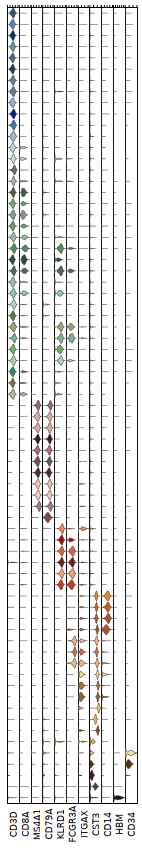

In [14]:
options(repr.plot.width = 30/25.4, repr.plot.height = 180/25.4)

fig_1_violins <- ggplot(violin_df, 
            aes(x=Expression, 
                y=xpos-1, 
                fill = label)) +
  geom_violin(scale = "width", 
              adjust = 1, 
              trim = TRUE,
              linewidth = 0.1) + 
  scale_fill_manual(values=color_vector)+  
  scale_x_continuous(expand = c(0, 0),  
                     position="top", 
                     labels = function(x) c(rep(x = "", times = length(x)-2), x[length(x) - 1], "")
                     ) +  
  scale_y_reverse(limits=c(70.500000001, -0.50000001),
                     expand = c(0, 0))+
  facet_grid(cols = vars(Gene), 
             scales = "free", 
             switch = "x")  +  
  theme_cowplot(font_size = 6,
                line_size = 0.2) +
  theme(legend.position = "none", 
        panel.spacing = unit(0, "lines"),
        plot.title = element_text(hjust = 0.5),
        panel.background = element_rect(fill = NA, 
                                        color = "black"),
        strip.background = element_blank(),
        strip.text = element_text(),
        strip.text.x.top = element_blank(),
        strip.text.x.bottom = element_text(angle = 90),
        axis.title.x = element_blank(),
        axis.text.x.top = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),  
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        theme(panel.border = element_rect(colour = "grey", linewidth = 0.1, fill = NA)) 
        + ylab(NULL))

fig_1_violins

In [39]:
counts_df=adata$obs %>% 
    group_by(AIFI_L3) %>% 
    summarise(count = n(), .groups = 'drop') %>% 
    ungroup() %>% 
    as.data.frame()

counts_df <- left_join(counts_df, labels_df, by=c('AIFI_L3'='label'))
color_vector <- setNames(labels_df$color, labels_df$label)
counts_df$AIFI_L3<-factor(counts_df$AIFI_L3,levels=labels_df$label)
counts_df$AIFI_L3 <- factor(counts_df$AIFI_L3, levels = rev(levels(counts_df$AIFI_L3)))

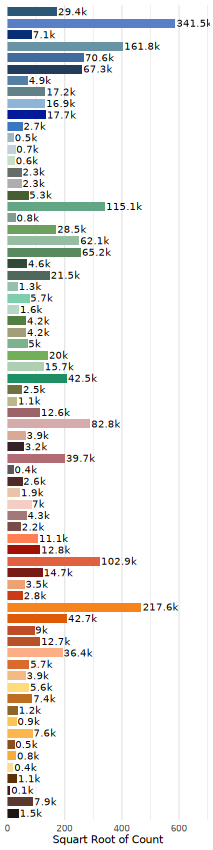

In [41]:
options(repr.plot.width = 45/25.4, repr.plot.height = 180/25.4)
fig_1_freq <- ggplot(counts_df, aes(y = AIFI_L3, x = sqrt(count), fill = AIFI_L3)) +
  geom_bar(stat = "identity", width=0.7) +
  scale_fill_manual(values=color_vector)+
  labs(x = " ", y = " ") +
  geom_text(aes(label =thousands_labels(count)), size=2.1, size.unit='mm',
            color='black',
            hjust = -0.05) +
  theme_minimal(base_size=6)+
  theme(axis.line = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.y = element_blank(),
        panel.background = element_blank(),
        panel.border = element_blank(),
        plot.background = element_blank(),
        legend.position = "none",
        panel.grid.major.y = element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_line(color = "grey90"),
        panel.grid.minor.x = element_line(color = "grey90")) +
  scale_x_continuous(name = "Squart Root of Count",expand = expansion(mult = c(0., 0.2)))

fig_1_freq

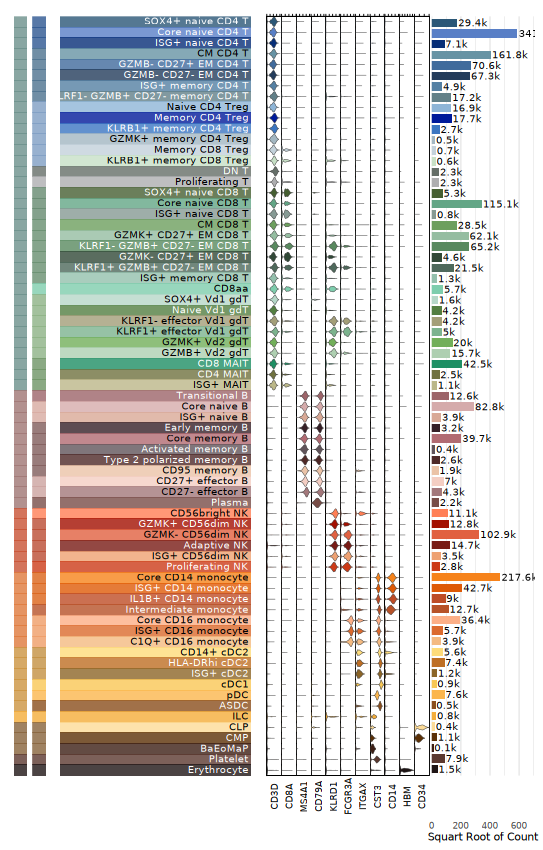

In [49]:
options(repr.plot.width = 115/25.4, repr.plot.height = 180/25.4)

fig_1_violins <- fig_1_violins + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
fig_1_freq <- fig_1_freq + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

combined <- L1_Annotation+L2_Annotation+L3_Annotation + fig_1_violins + fig_1_freq + plot_layout(widths = c(3,3,45, 35, 22)) 
combined


In [50]:
ggsave(filename = "FigureD.pdf", 
       plot = combined, 
       width = 115/25.4, 
       height = 180/25.4)